In [1]:
import pandas as pd
import os
import sys
sys.path.append(os.path.abspath('../../'))
import gwas_component.gwas_component as gc
import numpy as np
import pickle
from scipy.stats import linregress
import scipy.stats as st

def normalize_1d(x):
    ## x: (n, ) np array
    return (x - np.mean(x)) / (np.std(x) + 1e-5)

In [2]:
df_exp = pd.read_csv('../../processed_data/predixcan_1kgenome/TW_Whole_Blood_0.5.db_predicted_expression.txt.gz', 
                     sep = '\t', index_col= 'IID')
df_exp.columns = [g.split('.')[0] for g in df_exp.columns]

In [3]:
path_exp = 'single_component/'
fns = [[(path_exp + 'metaxcan/single_component_10_00_Whole_Blood.csv', path_exp + 'traits/single_component_10_00.tsv'),
       (path_exp + 'metaxcan/single_component_05_00_Whole_Blood.csv', path_exp + 'traits/single_component_05_00.tsv'),
       (path_exp + 'metaxcan/single_component_02_00_Whole_Blood.csv', path_exp + 'traits/single_component_02_00.tsv'),
      ]]


0.08992532701508471 0.16906986433046658
0.06522824304535829 0.5392506966271357
0.08208620237010422 0.2542015407629774


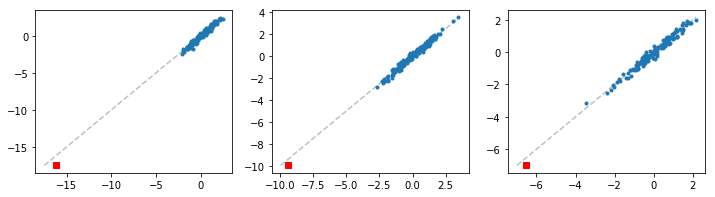

In [4]:
import matplotlib.pyplot as plt
% matplotlib inline

tissue = tissue0 = 'Whole_Blood'
gmodel = gc.Coexpression_Model(tissue)
    
fig, axes = plt.subplots(1, 3, figsize = (12, 3))
for i, fns0 in enumerate(fns):
    for j, (fn_meta, fn_trait) in enumerate(fns0):
        gene2z = gc.metaxcan_file_to_gene2z(fn_meta)
        df_trait = pd.read_csv(fn_trait, sep = '\t', index_col= 'IID')
        
        vec_trait = df_trait.loc[df_exp.index].phenotype.values
        
        coexp_asso_prex = []
        coexp_asso_meta, _, _ = gmodel.compute_z(gene2z)

        s0 = set(gmodel.id2gene)
        for k, pca_genes, pca_weight, sig_1k in gmodel.pca_models:

            mat = df_exp[[g for g in pca_genes if g in s0]].values
            pca_weight1_slice = np.array([v for g, v in zip(pca_genes, pca_weight) if g in s0])

            true_pheno = pca_weight1_slice.dot(mat.T) 

            exp_vec = normalize_1d(true_pheno) 
            slope, intercept, r_value, p_value, std_err = linregress(exp_vec, vec_trait)

            coexp_asso_prex.append(np.sign(slope) * st.norm.ppf(p_value / 2.0))
        coexp_asso_prex = np.array(coexp_asso_prex)
        
        vmax = max([np.max(coexp_asso_prex), np.max(coexp_asso_meta)])
        vmin = min([np.min(coexp_asso_prex), np.min(coexp_asso_meta)])
        ax = axes[j]
        ax.plot([vmin, vmax], [vmin, vmax], '--', color ='gray', alpha = 0.5)
        ax.plot(coexp_asso_meta, coexp_asso_prex, '.')
        ax.plot(coexp_asso_meta[80], coexp_asso_prex[80], 'rs')
        
        ind = np.array([i0 for i0 in range(len(coexp_asso_meta)) if i0 != 80])
        
        k, p = st.kstest(coexp_asso_meta[ind], lambda x: st.norm.cdf(x, loc=0, scale=1))
        print k, p
        #plt.axhline(0)
plt.show()